# Info

This script fits Fermi data using Gaussian functions. 

Uses:
- lmfit

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 9/2018

Last modified by Jerry LaRue, larue@chapman.edu, 03/2020

# Select Data

In [1]:
import numpy as np
from pandas import DataFrame as df
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, Layout
from IPython.display import clear_output
import sys
import string
from importlib import reload

sys.path.insert(0, '../src/')
import analysis_tools
reload(analysis_tools)

##### Button Functions #####

def UpdateFiles_Clicked(b):
    Fit = __import__(SelectRun.value.replace('.py',''))
    reload(Fit)
    Par = Fit.Parameters(SelectRegion.value)
    SelectFile.options = analysis_tools.FileList(Par['FolderPath'],Par['Runs'])

##### Widgets #####

SelectRun = widgets.Dropdown(
    options = analysis_tools.FileList(os.getcwd(),'.py'),
    description = 'Select Run',
    layout = Layout(width='40%'),
    style = {'description_width': '150px'},
    disabled = False,
)

SelectRegion = widgets.Dropdown(
    options = ['Pi Star','Middle','Shape Resonance'],
    description = 'Select Run',
    layout = Layout(width='40%'),
    style = {'description_width': '150px'},
    disabled = False,
)

UpdateFiles = widgets.Button(description="Update",layout = Layout(width='10%'))
UpdateFiles.on_click(UpdateFiles_Clicked)

Fit = __import__(SelectRun.value.replace('.py',''))
reload(Fit)
Par = Fit.Parameters(SelectRegion.value)

SelectFile = widgets.Dropdown(
    options=analysis_tools.FileList(Par['FolderPath'],Par['Runs']),
    description='Select File',
    layout=Layout(width='50%'),
    style = {'description_width': '150px'},
    disabled=False,
)

FitBackground = widgets.Checkbox(
    value=False,
    description='Fit Background',
    layout=Layout(width='50%'),
    style = {'description_width': '150px'},
    disabled=False
)

display(widgets.Box([SelectRun,UpdateFiles]))
display(SelectFile)
display(SelectRegion)
display(FitBackground)

Box(children=(Dropdown(description='Select Run', layout=Layout(width='40%'), options=('Fit 1-2 CO-O Hor Pi.py'…

Dropdown(description='Select File', layout=Layout(width='50%'), options=('XAS_018_020_bin_50.h5',), style=Desc…

Dropdown(description='Select Run', layout=Layout(width='40%'), options=('Pi Star', 'Middle', 'Shape Resonance'…

Checkbox(value=False, description='Fit Background', layout=Layout(width='50%'), style=DescriptionStyle(descrip…

# Fit Data

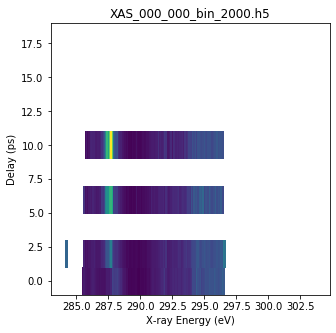

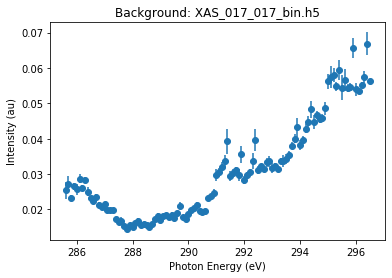

Box(children=(BoundedFloatText(value=286.0, description='ROI Min:', layout=Layout(width='20%'), max=310.0, min…

Box(children=(BoundedFloatText(value=7.0, description='Number of Peaks:', layout=Layout(width='20%'), max=10.0…

Checkbox(value=False, description='Normalize Data', layout=Layout(width='50%'), style=DescriptionStyle(descrip…

Button(description='Fit Data', style=ButtonStyle())

Output()

In [13]:
import analysis_tools
reload(analysis_tools)

global Energy, Signal, FitParameters

##### Functions #####

def CopyParameters() :
    global FitParameters
    ToCopy = FitParameters
    ToCopy.to_clipboard()

def CopyData() :
    global Energy, Delay, Signal
    ToCopy = Energy
    ToCopy = np.zeros((Signal.shape[0]+1,len(Energy)))
    ToCopy[0] = Energy
    i = 0
    while i < Signal.shape[0] :
        ToCopy[i+1] = Signal[i]
        i += 1
    ToCopy = np.transpose(ToCopy)
    ToCopy = df(data=ToCopy,columns=np.concatenate((['Energy'],Delay)))
    ToCopy.to_clipboard()
    print(Signal)

##### Button Functions #####

def ParametersToClipboard_Clicked(b):
    CopyParameters()

def DataToClipboard_Clicked(b):
    CopyData()
    
def FitData_Clicked(b):
    
    global Energy, Delay, Signal, FitParameters
    
    with out:
        
        clear_output(True)
        print('_'*110)
        print("")
        
        Fit = __import__(SelectRun.value.replace('.py',''))
        reload(Fit)
        Par = Fit.Parameters(SelectRegion.value)
        
        ##### Prepare data #####

        Energy, Signal, Delay, ErrorBars = analysis_tools.ImportData(Par['FolderPath'],SelectFile.value)
        ScalingFactor = Par['ScalingFactor']
        if ScalingFactor != 1 :
            print('Warning, data is being scaled by '+str(ScalingFactor))
        Signal = Signal * ScalingFactor
        ErrorBars = ErrorBars * ScalingFactor
        Energy = Energy + Par['xOffset']
        if Par['BackgroundRun'] != 'None' :
            Background_Energy, Background, Background_Delay, Background_ErrorBars = analysis_tools.ImportData(Par['FolderPath'],Par['BackgroundRun'])
            Background_Energy = Background_Energy + Par['xOffset']
        NormROI_Min, NormROI_Max = Par['NormROI']
        if NormalizeData.value == True :
            Energy, Signal = analysis_tools.Normalize(Energy,Signal,Par['NormROI'][0], Par['NormROI'][1])
            if Par['BackgroundRun'] != 'None' :
                Background_Energy, Background = analysis_tools.Normalize(Background_Energy,Background,Par['NormROI'][0], Par['NormROI'][1])
        Energy, Signal, Delay, ErrorBars = analysis_tools.TrimData(Energy,Signal,Delay,ErrorBars,ROI_Min.value,ROI_Max.value)
        if Par['BackgroundRun'] != 'None' :
            if FitBackground.value == 'Fit' :
                Signal = analysis_tools.SubtractBackground(Energy,Signal,Background_Energy,Background_Fit,ROI_Min.value,ROI_Max.value)
            else :
                Signal = analysis_tools.SubtractBackground(Energy,Signal,Background_Energy,Background,ROI_Min.value,ROI_Max.value)

        ##### Plot all data #####

        plt.figure(figsize = [12,6])
        i = 0
        while i < len(Signal) :
            plt.plot(Energy,Signal[i],'-o', ms=3, lw=1,label=(str(round(Delay[i]*1e-3,2))+' ps'))
            i+= 1
#         plt.plot((287.3,287.3),(0,max(y)),'k:',label='CO Gas Phase')
        plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.2, 1), ncol=1)
        plt.show()
        
        if NumberPeaks.value != 0 or NumRefPeaks.value != 0 :

            print('_'*110)

            Fits, FitParameters, Fit_Energy, Fit_Signal = Fit.FitData(Energy,Delay,Signal,ErrorBars,SelectRegion.value,NumberPeaks.value,NumRefPeaks.value)

            analysis_tools.PlotAnalysis('amp',FitParameters,Fits.ParameterNames)
            analysis_tools.PlotAnalysis('ω',FitParameters,Fits.ParameterNames)
            analysis_tools.PlotAnalysis('σ',FitParameters,Fits.ParameterNames)
            analysis_tools.PlotDataAndFits(Energy, Signal, Fit_Energy, Fit_Signal, Delay)

            ParametersToClipboard = widgets.Button(description="Copy parameters")
            ParametersToClipboard.on_click(ParametersToClipboard_Clicked)
        
            DataToClipboard = widgets.Button(description="Copy data")
            DataToClipboard.on_click(DataToClipboard_Clicked)
            display(widgets.Box([DataToClipboard,ParametersToClipboard]))
        
        else :
            DataToClipboard = widgets.Button(description="Copy data")
            DataToClipboard.on_click(DataToClipboard_Clicked)
            display(DataToClipboard)

##### Parameters #####

Fit = __import__(SelectRun.value.replace('.py',''))
reload(Fit)
Par = Fit.Parameters(SelectRegion.value)

Energy, Signal, Delay, ErrorBars = analysis_tools.ImportData(Par['FolderPath'],SelectFile.value)
Energy = Energy + Par['xOffset']

##### Plot Data #####

plt.figure(figsize = [5,5])
plt.pcolor(Energy, Delay*1e-3, Signal)
plt.xlabel('X-ray Energy (eV)')
plt.ylabel('Delay (ps)')
plt.title(SelectFile.value)
plt.show()

if Par['BackgroundRun'] != 'None' :
    
    Background_Energy, Background, Background_Delay, Background_ErrorBars = analysis_tools.ImportData(Par['FolderPath'],Par['BackgroundRun'])
    Background_Energy = Background_Energy + Par['xOffset']

    # Check data structure
    
    if Background.shape[0] != 1 :
        raise HaltException('Background data exceeds allowed dimensions')
    
    ##### Plot background data #####
    
    x = Background_Energy
    y = Background[0]
    err = Background_ErrorBars[0]
    plt.plot(x, y,'r.', label='data')
    plt.errorbar(x, y, yerr=err, fmt='o')
    plt.xlabel('Photon Energy (eV)'), plt.ylabel('Intensity (au)')
    plt.title('Background: '+Par['BackgroundRun'])
    
    ##### Fit positive delay data #####
    
    if FitBackground.value == True :
        Model = PolynomialModel(4)
        Params = Model.make_params(c0=55, c1=-0.4,
                                c2=0.001, c3=0.001, c4=0.01,c5=0.01)
        Fit = Model.fit(y, Params, x=x)
        Comps = Fit.eval_components(Fit.params, x=x)
        Background_Fit = Comps['polynomial']
        plt.plot(x, Comps['polynomial'], 'k--', label='Baseline')

    plt.show()

##### Widgets #####

ROI_Min = widgets.BoundedFloatText(
    value=Par['ROI'][0],
    min=280,
    max=310,
    step=0.1,
    description='ROI Min:',
    layout=Layout(width='20%'),
    style = {'description_width': '130px'},
    disabled=False
)

ROI_Max = widgets.BoundedFloatText(
    value=Par['ROI'][1],
    min=280,
    max=310,
    step=0.1,
    description='ROI Max:',
    layout=Layout(width='24%'),
    style = {'description_width': '170px'},
    disabled=False
)

NumberPeaks = widgets.BoundedFloatText(
    value=int(Par['NumPeaks']),
    min=0,
    max=10,
    step=1,
    description='Number of Peaks:',
    layout=Layout(width='20%'),
    style = {'description_width': '130px'},
    disabled=False
)

NumRefPeaks = widgets.BoundedFloatText(
    value=int(Par['NumRefPeaks']),
    min=0,
    max=2,
    step=1,
    description='Number of Reference Peaks:',
    layout=Layout(width='24%'),
    style = {'description_width': '170px'},
    disabled=False
)

NormalizeData = widgets.Checkbox(
    value=False,
    description='Normalize Data',
    layout=Layout(width='50%'),
    style = {'description_width': '130px'},
    disabled=False
)

display(widgets.Box([ROI_Min,ROI_Max]))
display(widgets.Box([NumberPeaks,NumRefPeaks]))
display(NormalizeData)

##### Fit data #####

FitData = widgets.Button(description="Fit Data")
FitData.on_click(FitData_Clicked)
display(FitData)

out = widgets.Output()
out